In [1]:
import numpy as np
from sklearn import metrics
import spacy
import time
import pickle

In [2]:
#load data
train_r = pickle.load(open("train_r.pkl", "rb"))
train_b = pickle.load(open("train_b.pkl", "rb"))
print(train_r[0])

north korea calls trump warning a load of nonsense


In [3]:
nlp = spacy.load("en")

In [4]:
doc = spacy.tokens.Doc(nlp.vocab, words = train_r[0])

In [5]:
tokens = nlp(train_r[0])
for token in tokens:
    print(token.text, token.tag_, token.lemma_)

north NN north
korea NN korea
calls NNS call
trump VBP trump
warning VBG warn
a DT a
load NN load
of IN of
nonsense NN nonsense


In [6]:
#pass in the tags and lemmas instead, and determine how the performance is
#create 16 new features

# 1 Number of first-person pronouns
# 2 Number of second-person pronouns
# 3 Number of third-person pronouns
# 4 Number of coordinating conjunctions
# 5 Number of past-tense verbs
# 6 Number of future-tense verbs
# 7 Number of common nouns
# 8 Number of proper nouns
# 9 Number of adverbs
# 10 who words
# 11 Average length of sentences, in tokens

def make_feats(lines):
    data =np.zeros((len(lines), 11))
    first_person = ["I", 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']
    second_person = ['you', 'your', 'yours', 'u', 'ur', 'urs']
    third_person =['he', 'min', 'his','she', 'her', 'hers', 'it', 'its', 'they' , 'them' ,'their', 'theirs']
    future_tense = ["'ll", 'will', 'gonna','going to']
    for i, line in enumerate(lines):
        doc = spacy.tokens.Doc(nlp.vocab, words = line)
        tokens = nlp(line)
        total = 0
        for token in tokens:
            total+=1
            if token.text in first_person:
                data[i, 0] +=1
            elif token.text in second_person:
                data[i, 1] +=1
            elif token.text in third_person:
                data[i, 2] +=1
            elif token.text in future_tense:
                data[i, 5] +=1
            if token.tag_ == "CC":
                data[i, 3] +=1
            elif token.tag_ == "VBD":
                data[i, 4] +=1
            elif token.tag_ == "NNS" or token.tag_== "NN":
                data[i, 6] +=1
            elif token.tag_ == "NNPS" or token.tag_ == "NNP" :
                data[i, 7]
            elif token.tag_ == "RB" or token.tag_ == "RBR" or token.tag_ == "RBS":
                data[i, 8]+=1
            elif token.tag_ == "WDT" or token.tag_ =="WP" or token.tag_ == "WP$" or token.tag_=="WRB":
                data[i, 9] +=1
        data[i, 10] = total
    return data

In [7]:
#tag_counts_r = np.zeros((len(train_r), 11 ))
tag_counts_r = make_feats(train_r)
tag_counts_b = make_feats(train_b)

In [8]:
print(tag_counts_r[:3, :])
print(tag_counts_b[:3, :])

[[ 0.  0.  0.  0.  0.  0.  5.  0.  0.  0.  9.]
 [ 1.  0.  0.  0.  0.  0.  5.  0.  1.  1. 10.]
 [ 0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  8.]]
[[ 0.  0.  1.  0.  0.  0.  6.  0.  0.  0. 13.]
 [ 0.  0.  0.  0.  0.  0.  8.  0.  1.  0. 19.]
 [ 0.  0.  0.  0.  0.  0. 11.  0.  0.  1. 23.]]


In [9]:
#train on these features
y_Y = np.ones(len(train_r))
n_Y = np.zeros(len(train_b))
Y = np.concatenate((y_Y, n_Y))
X = np.concatenate((tag_counts_r, tag_counts_b))

In [10]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 0, n_estimators = 200, max_depth = 10, max_features=None, class_weight="balanced") 

In [11]:
from sklearn.model_selection import cross_val_score

In [12]:
score = cross_val_score(rfc, X, Y, cv = 5, n_jobs = -1, scoring="accuracy")
print(score, np.mean(score), np.std(score))
score = cross_val_score(rfc, X, Y, cv = 5, n_jobs = -1, scoring="average_precision")
print(score, np.mean(score), np.std(score))

[0.79039301 0.80131004 0.81004367 0.79868709 0.79166667] 0.7984200962546064 0.007121423729663044
[0.86891311 0.86631563 0.81978386 0.84873625 0.84702425] 0.8501546203557888 0.017591210005234937


In [12]:
# try on the validation data 
valid_r = pickle.load(open("valid_r.pkl", "rb"))
valid_b = pickle.load(open("valid_b.pkl", "rb"))
v_y_Y = np.ones(len(valid_r))
v_n_Y = np.zeros(len(valid_b))
validY = np.concatenate((v_y_Y, v_n_Y))
print(validY[:10])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
#create valid features
#valid_counts_r = np.zeros((len(train_b), 11 ))
valid_r_counts = make_feats(valid_r)
valid_b_counts = make_feats(valid_b)
v_X = np.concatenate((valid_r_counts, valid_b_counts))

In [14]:
print(v_X.shape)
print(valid_r_counts[:3, :])
print(valid_b_counts[:3, :])

(490, 11)
[[ 0.  0.  0.  1.  0.  0.  2.  0.  0.  0.  5.]
 [ 0.  0.  0.  0.  1.  0.  4.  0.  0.  0.  7.]
 [ 0.  0.  0.  0.  1.  0.  5.  0.  0.  0. 10.]]
[[ 0.  0.  1.  1.  0.  0.  2.  0.  0.  0.  9.]
 [ 0.  0.  0.  0.  0.  0.  6.  0.  0.  0. 13.]
 [ 1.  0.  0.  1.  1.  0.  5.  0.  0.  0. 15.]]


In [16]:
# drops a little during validation, which makes sense
score = cross_val_score(rfc, v_X, validY, cv = 5, n_jobs = -1, scoring="accuracy")
print(score, np.mean(score), np.std(score))
score = cross_val_score(rfc, v_X, validY, cv = 5, n_jobs = -1, scoring="average_precision")
print(score, np.mean(score), np.std(score))

[0.80612245 0.82653061 0.73469388 0.78571429 0.75510204] 0.7816326530612244 0.03328470700061243
[0.86659697 0.88274729 0.84717605 0.90707864 0.83753978] 0.8682277479534445 0.02493108034740239


In [15]:
#the performance is less, and doesn't match native bayes validation accuracy. 
#However, the gain in creating these features is significant

In [16]:
#whats happens if you conbine the two sets of features 
trainX = np.concatenate((train_r, train_b))
#gerenate feature vectors 
total_words = {}
for line in trainX:
    words = line.split(" ")
    for word in words:
        if word == "":
            continue
        try:
            total_words[word]
        except:
            total_words[word] = True

print(len(total_words.keys()))
#dont add words in valid and test sets

4818


In [37]:
unique_keys[:10]
pickle.dump(unique_keys, open("train_set_keys.pkl", "wb"))
unique_keys[:10]

['0', '00', '000', '1', '10', '100', '100mln', '10m', '11', '11yo']

In [17]:
#create training feats

#print(len(validX))
unique_keys = list(total_words.keys())
unique_keys.sort()
#print(unique_keys[:10])
#account for a bias
train_feats = np.zeros((len(trainX), len(total_words.keys()) ))
for i, line in enumerate(trainX):
    words = line.split(" ")
    #print(words)
    for word in words:
        if word =="":
            continue
        #print(unique_keys.index(word))
        ind = unique_keys.index(word)  
        #plus one is so that the very first is the bias (here a bias of zero)
        train_feats[i][ind] = 1

valid_X = np.concatenate((valid_r, valid_b))

#create testing features
valid_feats = np.zeros((len(valid_X), len(total_words.keys())))
for i , line in enumerate(valid_X):
    words = line.split(" ")
    #print(len(words), end = " ")
    #if i ==0:
        #print(words)
    #print(words)
    for word in words:
        if word =="":
            continue
        #account for value error:
        try:
            ind = unique_keys.index(word) 
            #print(ind)
            valid_feats[i][ind] = 1
        except:
            continue       
#inds = np.where(valid_feats ==1)[1]
#print("\n", inds[:34])

In [18]:
#concat the features
print(train_feats.shape, X.shape)
new_trainX = np.concatenate((train_feats, X), axis = 1)
print(valid_feats.shape, v_X.shape)
new_validX = np.concatenate((valid_feats, v_X), axis =1)

(2287, 4818) (2287, 11)
(490, 4818) (490, 11)


In [23]:
score = cross_val_score(rfc, new_trainX, Y, cv = 5, n_jobs = -1, scoring="accuracy")
print(score, np.mean(score), np.std(score))
score = cross_val_score(rfc, new_trainX, Y, cv = 5, n_jobs = -1, scoring="average_precision")
print(score, np.mean(score), np.std(score))

[0.86244541 0.80131004 0.84497817 0.84682713 0.80921053] 0.83295425684983 0.023545192559592677
[0.92598627 0.90943403 0.92948298 0.94504814 0.92767628] 0.9275255392410375 0.011318727931270976


In [24]:
rfc2 = RandomForestClassifier(random_state = 0, n_estimators = 500, min_samples_split=5, class_weight = "balanced") 

In [25]:
#%%time
score = cross_val_score(rfc2, new_trainX, Y, cv = 5, n_jobs = -1, scoring="accuracy")
print(score, np.mean(score), np.std(score))
score = cross_val_score(rfc2, new_trainX, Y, cv = 5, n_jobs = -1, scoring="average_precision")
print(score, np.mean(score), np.std(score))

[0.86681223 0.84716157 0.87336245 0.84463895 0.83552632] 0.8535003020005462 0.014237129857831451
[0.93912189 0.93096109 0.96153671 0.95059447 0.92317498] 0.941077829381619 0.01368077569395519
CPU times: user 1.99 s, sys: 204 ms, total: 2.2 s
Wall time: 2min 16s


In [26]:
rfc2.fit(new_trainX, Y)
preds = rfc2.predict(new_validX)
print(metrics.accuracy_score(validY, preds))
print(metrics.average_precision_score(validY, preds))

0.863265306122449
0.835762327529882


In [41]:
# plot feature importances with spacy tokens here
# do feature score evaluation
importances = rfc2.feature_importances_
import_keys = np.argsort(importances)[::-1]
print(import_keys[:10])
import_keys = np.flip(import_keys, axis = 0)
print(import_keys)
importances = np.sort(importances)
importances = np.flip(importances, axis = 0)

[4828 4824 4285 1333 2016 4429 4826 4413 4820 4525]
[1914 3647 2411 ... 4285 4824 4828]


In [42]:
x = np.arange(10)
print(x, importances[:10])
print(import_keys[:10])
## 1 Number of first-person pronouns
# 2 Number of second-person pronouns
# 3 Number of third-person pronouns
# 4 Number of coordinating conjunctions
# 5 Number of past-tense verbs
# 6 Number of future-tense verbs
# 7 Number of common nouns
# 8 Number of proper nouns
# 9 Number of adverbs
# 10 who words
# 11 Average length of sentences, in tokens
unique_keys = np.asarray(unique_keys)
new_keys = ["FirstP", "SecondP", "ThirdP", "CcomConj", "PresTV", "FutureTV", "CommonN", "ProperN", "Adverb", "WHO", "LENGTH"]
new_unique_keys = np.concatenate((unique_keys, new_keys))
print(new_unique_keys[import_keys[:10]])

[0 1 2 3 4 5 6 7 8 9] [0.12039155 0.03316927 0.02765408 0.02416592 0.01765351 0.01519242
 0.01259255 0.01120186 0.01009837 0.00778613]
[1914 3647 2411 1291 4825  626 2551 2747 3452 2289]
['hair' 'rnc' 'kurdish' 'disqualification' 'ProperN' 'brought' 'locker'
 'mired' 'rebecca' 'jabs']


In [45]:
from matplotlib import pyplot as plt
import matplotlib

In [46]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
#matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **font)

/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


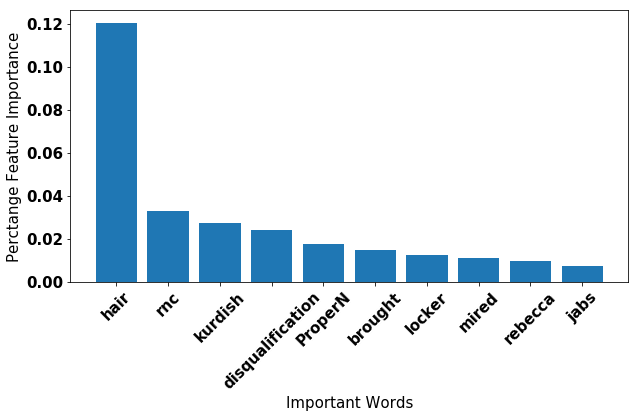

In [47]:
fig  = plt.figure(figsize=(10,5))
ax = fig.add_subplot("111")
#ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(x, importances[:10])
ax.set_xticks(x)
plt.ylabel("Perctange Feature Importance")
plt.xlabel("Important Words")
ax.set_xticklabels(new_unique_keys[import_keys[:10]], rotation = 45)
plt.show()

In [19]:
#visualize the first training sentence
doc = spacy.tokens.Doc(nlp.vocab, words = train_r[0])
tokens = nlp(train_r[0])
print(tokens)
options = {"word_spacing":45, "distance": 105}
spacy.displacy.render(tokens, style="dep", jupyter = True, options=options)

north korea calls trump warning a load of nonsense


In [20]:
#visualize the first training sentence
doc = spacy.tokens.Doc(nlp.vocab, words = train_b[3])
tokens = nlp(train_b[3])
print(tokens)
options = {"word_spacing":45, "distance": 105}
spacy.displacy.render(tokens, style="dep", jupyter = True, options=options)

democrats plan to burn down u if trump elected


In [21]:
#try using svm model
from sklearn.svm import SVC

In [22]:
svc = SVC(random_state=0, kernel="rbf", class_weight="balanced", max_iter=10000, verbose = True, gamma = 0.1)

In [52]:
score = cross_val_score(svc, new_trainX, Y, cv = 5, scoring="accuracy", verbose = 4, n_jobs = -1)
print(score)
print(np.mean(score))

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[LibSVM][CV] ....................... , score=0.8537117903930131, total=  47.7s
[CV]  ................................................................
[LibSVM][CV] ....................... , score=0.8580786026200873, total=  54.8s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   55.4s remaining:  1.4min


[LibSVM][CV] ....................... , score=0.8665207877461707, total=  55.8s
[LibSVM][CV] ....................... , score=0.8558951965065502, total=  56.9s
[LibSVM][CV] ....................... , score=0.8179824561403509, total=  30.4s
[0.85371179 0.8558952  0.8580786  0.86652079 0.81798246]
0.8504377666812346


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


In [54]:
score = cross_val_score(svc, new_trainX, Y, cv = 5, scoring="average_precision", verbose = 4, n_jobs = -1)
print(score)
print(np.mean(score))

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[LibSVM][CV] ....................... , score=0.9321254873238951, total=  52.6s
[CV]  ................................................................
[LibSVM][CV] ........................ , score=0.950748744183324, total=  57.1s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   57.7s remaining:  1.4min


[LibSVM][CV] ....................... , score=0.9428891503219047, total=  58.5s
[LibSVM][CV] ....................... , score=0.9311364963189293, total=  59.0s
[LibSVM][CV] ....................... , score=0.9294172144136277, total=  26.1s
[0.93212549 0.9311365  0.95074874 0.94288915 0.92941721]
0.9372634185123362


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


In [55]:
#try gradient boosting as the third model, then take the majority vote
# try KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors= 10, n_jobs = -1)
#should scale data for this
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#c.fit(new_trainX)
#mention how score lowered when dats was scaled
#norm_new_trainX = sc.transform(new_trainX)
#norm_new_validX = sc.transform(new_validX)
score = cross_val_score(knn,new_trainX, Y, cv = 5, n_jobs = -1, verbose = 5, scoring = "accuracy")
print(score, np.mean(score))

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................... , score=0.8231441048034934, total=  10.4s
[CV]  ................................................................
[CV] ....................... , score=0.8449781659388647, total=  10.8s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.0s remaining:   16.6s


[CV] ....................... , score=0.8493449781659389, total=  11.1s
[CV] ....................... , score=0.8315098468271335, total=  11.0s
[CV] ....................... , score=0.8135964912280702, total=   5.5s
[0.84497817 0.8231441  0.84934498 0.83150985 0.81359649] 0.8325147173927


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s finished


In [56]:
knn.fit(new_trainX, Y)
preds = knn.predict(new_validX)
print(metrics.accuracy_score(preds, validY))
print(metrics.average_precision_score(preds, validY))

rfc2.fit(new_trainX, Y)
preds_1 = rfc2.predict(new_validX)
print(metrics.accuracy_score(validY, preds_1))
print(metrics.average_precision_score(validY, preds_1))

svc.fit(new_trainX, Y)
preds_2 = svc.predict(new_validX)
print(metrics.accuracy_score(validY, preds_2))
print(metrics.average_precision_score(validY, preds_2))

0.8489795918367347
0.9134527443991598
0.863265306122449
0.835762327529882
[LibSVM]0.8591836734693877
0.8320383395040376


In [57]:
#print(preds)
#print(preds_1)
final_and_preds = (preds_1*preds_2*preds) #+ (preds_1*preds) + (preds*preds_2)
#final_or_preds = preds_1+preds_2
print(metrics.accuracy_score(validY, final_and_preds))
print(metrics.average_precision_score(validY, final_and_preds))


0.8448979591836735
0.8314954912993894


In [23]:
#test performance of all these with nn
print(new_trainX.shape)

(2287, 4829)


In [24]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)

In [25]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        self.features = nn.Sequential(
        # an affine operation: y = Wx + b
        nn.Linear(new_trainX.shape[1], 200),
        nn.ReLU(),
        #nn.Linear(2000, 200),
        #nn.ReLU(),
        #nn.Dropout( 0.1),
        nn.Linear(200, 20),
        nn.ReLU(),
        nn.Linear(20, 2), # final two classees, real or fake
    )

    def forward(self, x):
        # If the size is a square you can only specify a single number
        x = self.features(x)
        return x

net = Net()
print(net)

Net(
  (features): Sequential(
    (0): Linear(in_features=4829, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)


In [26]:
#train_feats, trainY
dtype_float = torch.FloatTensor
dtype_long = torch.LongTensor
print(train_feats.shape)#, valid_feats
loss_fn = torch.nn.CrossEntropyLoss()
from torch.autograd import Variable
x_data = Variable(torch.from_numpy(new_trainX), requires_grad = False).type(dtype_float)
x_valid_data = Variable(torch.from_numpy(new_validX), requires_grad = False).type(dtype_float)
y_classes = Variable(torch.from_numpy(Y), requires_grad = False).type(dtype_long)

#net.forward(x_data)
print(y_classes.shape)
learning_rate = 1e-3
#optimal, lr = 2e-3, weight decay = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay=0.01)
#softmax = torch.nn.Softmax()0
net.forward(x_data)


(2287, 4818)
torch.Size([2287])


Variable containing:
 0.0735  0.1894
 0.0775  0.1939
 0.0680  0.1949
       ⋮        
 0.0492  0.1736
 0.0618  0.1824
 0.0677  0.1880
[torch.FloatTensor of size 2287x2]

In [27]:
#%%time
for t in range(1000):
    #print 'hey'
    y_pred = net(x_data)
    #print y_pred
    loss = loss_fn(y_pred, y_classes)
    
    optimizer.zero_grad() #model.zero_grad()  # Zero out the previous gradient computation
    loss.backward()    # Compute the gradient
    optimizer.step()   # Use the gradient information to 
                   # make a step
    print(t, loss.data[0])
    #if t %100 ==99:
    #    print(t)

#print "hel

0 0.6837456822395325
1 0.6808848977088928
2 0.6777369976043701
3 0.6749200224876404
4 0.6718400716781616
5 0.668483316898346
6 0.6648978590965271
7 0.6610564589500427
8 0.6569338440895081
9 0.6522485017776489
10 0.6468033790588379
11 0.6413451433181763
12 0.6355941295623779
13 0.6294041275978088
14 0.6227185130119324
15 0.6155015826225281
16 0.6077702045440674
17 0.5995270609855652
18 0.5907649993896484
19 0.5815044641494751
20 0.5717987418174744
21 0.5616547465324402
22 0.5510494112968445
23 0.5400202870368958
24 0.5286377668380737
25 0.5169503688812256
26 0.5050110220909119
27 0.49288955330848694
28 0.48063069581985474
29 0.46830254793167114
30 0.45599138736724854
31 0.4437576234340668
32 0.43165817856788635
33 0.41973885893821716
34 0.4080491065979004
35 0.396638423204422
36 0.3855469822883606
37 0.3748076856136322
38 0.3644418716430664
39 0.3544769585132599
40 0.3449274003505707
41 0.33580130338668823
42 0.3270987272262573
43 0.3188230097293854
44 0.31097450852394104
45 0.303543776

In [29]:
net.eval()
y_pred = net(x_valid_data)
preds = torch.max(y_pred, 1)
#print(preds[1].data)
from sklearn import metrics
#print(x_data.shape, x_valid_data.shape)
#print(preds)
y_train_pred = net(x_data)
train_preds = torch.max(y_train_pred, 1)

In [30]:
print(metrics.accuracy_score(Y, train_preds[1].data))
print(metrics.average_precision_score(Y, train_preds[1].data))

print(metrics.accuracy_score(validY, preds[1].data))
a_score = (metrics.accuracy_score(validY, preds[1].data))
print(metrics.average_precision_score(validY, preds[1].data))
score =metrics.average_precision_score(validY, preds[1].data) 


0.9991254919108001
0.9985507246376811
0.8795918367346939
0.8753036242745685


In [31]:
#save model_weights to be used in the bonus
torch.save(net.state_dict(), "bonus_model_weights.pkl")

/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


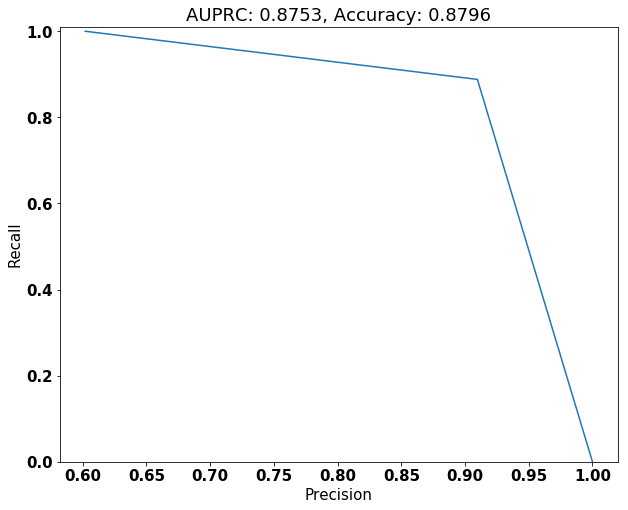

In [74]:
#plot graphs
# plot graph
plt.figure(figsize=(10,8))
precision, recall, thresh = metrics.precision_recall_curve(validY, preds[1].data)
plt.plot(precision, recall)
plt.title("AUPRC: {0:.04}, Accuracy: {1:.04}".format(score, a_score))
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.ylim([0,1.01])
plt.show()

In [77]:
# confusion matrix
cm = metrics.confusion_matrix(validY, preds[1].data)
print(cm)

[[169  26]
 [ 33 262]]


In [84]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=25)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [28]:
import itertools

Confusion matrix, without normalization
[[169  26]
 [ 33 262]]


/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


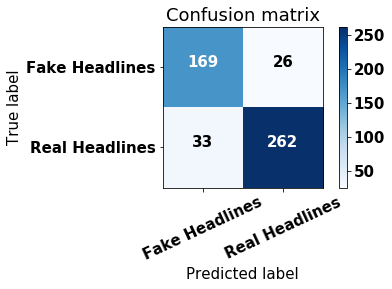

In [86]:
plot_confusion_matrix(cm, ["Fake Headlines", "Real Headlines"])
plt.show()